In [162]:
import os
import sys
import pickle
import glob
import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import pandas as pd
from skimage.transform import rotate
import nibabel as nib

data_root_folder = '../data/'
class ISICDataset(Dataset):
    def __init__(self, folder, mode ='train'):
    #def __init__(self, args, data_path , transform = None, mode = 'Training',plane = False):

        if (mode == 'train'):
            imgs_dir = os.path.join(data_root_folder, folder, 'Fold_2')
            img_dirs = sorted(glob.glob(os.path.join(imgs_dir, '*.gz')))
            imgs_dir = os.path.join(data_root_folder, folder, 'Fold_3')
            img_dirs.extend(sorted(glob.glob(os.path.join(imgs_dir, '*.gz'))))
            imgs_dir = os.path.join(data_root_folder, folder, 'Fold_4')
            img_dirs.extend(sorted(glob.glob(os.path.join(imgs_dir, '*.gz'))))
            print('Train DL')
        elif (mode == 'valid'):
            imgs_dir = os.path.join(data_root_folder, folder, 'Fold_5')
            img_dirs = sorted(glob.glob(os.path.join(imgs_dir, '*.gz')))
        elif (mode == 'test'):
            imgs_dir = os.path.join(data_root_folder, folder, 'Fold_1')
            img_dirs = sorted(glob.glob(os.path.join(imgs_dir, '*.gz')))

        self.img_dirs_dic = [(img[img.index('00'):img.index('_session')], [img]) for img in img_dirs]
        # print(self.img_dirs_dic[0:3])
        self.img_dirs_dic = {k: v for k, v in self.img_dirs_dic}
        img_dirs_ids = set(self.img_dirs_dic.keys())
        
        ## Get the truth masks dirs
        imgs_dir_fsl = os.path.join(data_root_folder, folder, 'Masks_dlbs')
        img_dirs_fsl = sorted(glob.glob(os.path.join(imgs_dir_fsl, '*.gz')))
        for imgdir in img_dirs_fsl:
            imgdir_id = imgdir[imgdir.index('00'):imgdir.index('_pve')]
            if (imgdir_id in img_dirs_ids):
                self.img_dirs_dic[imgdir_id].append(imgdir)

        for imgid in self.img_dirs_dic:
            assert len(self.img_dirs_dic[imgid]) == 4, 'There are some missing images or masks in {0}'.format(folder)
            
        self.ids = list(self.img_dirs_dic.keys())
        self.n_sample = len(self.img_dirs_dic.keys())


    def __len__(self):
        #return len(self.name_list)
        return self.n_sample

    def __getitem__(self, index):
        """Get the images"""
        '''
        name = self.name_list[index]
        img_path = os.path.join(self.data_path,name)
        
        mask_name = self.label_list[index]
        msk_path = os.path.join(self.data_path,mask_name)

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(msk_path).convert('L')
        
        #if self.mode == 'Training':
        #     label = 0 if self.label_list[index] == 'benign' else 1
        #else:
        #     label = int(self.label_list[index])

        if self.transform:
            state = torch.get_rng_state()
            img = self.transform(img)
            torch.set_rng_state(state)
            mask = self.transform(mask)

        print(img.shape) 
        print(mask.shape)   
        return (img, mask, name)
        '''        
        imgid = self.ids[index]
        
        # Read the actual image
        img = nib.load(self.img_dirs_dic[imgid][0]).get_fdata()
        mask0 = nib.load(self.img_dirs_dic[imgid][1]).get_fdata()
        mask1 = nib.load(self.img_dirs_dic[imgid][2]).get_fdata()
        mask2 = nib.load(self.img_dirs_dic[imgid][3]).get_fdata()
        
        # Resize images to (192, 192, 192)
        img = img[:,13:205,:]
        img = np.append(img, np.zeros((10, 192, 182)), axis=0)
        img = np.append(img, np.zeros((192, 192, 10)), axis=2)
        mask0 = mask0[:,13:205,:]
        mask0 = np.append(mask0, np.zeros((10, 192, 182)), axis=0)
        mask0 = np.append(mask0, np.zeros((192, 192, 10)), axis=2)
        mask1 = mask1[:,13:205,:]
        mask1 = np.append(mask1, np.zeros((10, 192, 182)), axis=0)
        mask1 = np.append(mask1, np.zeros((192, 192, 10)), axis=2)
        mask2 = mask2[:,13:205,:]
        mask2 = np.append(mask2, np.zeros((10, 192, 182)), axis=0)
        mask2 = np.append(mask2, np.zeros((192, 192, 10)), axis=2)
        
        #img = cv2.imread(os.path.join(self.imgs_dir, 'image_{0:04d}.png'.format(idx)), cv2.IMREAD_COLOR)
        # mask = cv2.imread(os.path.join(self.masks_dir, 'mask_{0:04d}.png'.format(idx)), cv2.IMREAD_GRAYSCALE)

        # Convert BGR to RGB
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Resize all images from 512 to 256 (H and W) ################################### Important Note: Remove the following lines to go back to the original resolution (512x512)
        #img = cv2.resize(img, (192,192))
        #print(img.shape)
        #mask = cv2.resize(mask, (192,192))
        
        # Scale between 0 to 1
        img = np.array(img) / 255.0
        mask0 = np.array(mask0) / 255.0
        mask1 = np.array(mask1) / 255.0
        mask2 = np.array(mask2) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask0[mask0 <= 0.5] = 0.0
        mask0[mask0 > 0.5] = 1.0
        mask1[mask1 <= 0.5] = 0.0
        mask1[mask1 > 0.5] = 1.0
        mask2[mask2 <= 0.5] = 0.0
        mask2[mask2 > 0.5] = 1.0
        
        # Add an axis to the mask array so that it is in [channel, width, height] format.
        #mask = np.expand_dims(mask, axis=0)
        img = img
        #mask = mask0
        mask = np.stack((mask0, mask1, mask2), axis=0)
        
        # HWC to CHW
        #img = np.transpose(img, (2, 0, 1))
        
        print(img.shape)
        print(mask.shape)
        return (torch.from_numpy(img).type(torch.FloatTensor),
          torch.from_numpy(mask).type(torch.FloatTensor),
          imgid)

        

In [163]:
folder = 'dlbs'

In [164]:
os.getcwd()

'C:\\Users\\Charlie\\Documents\\BMEN4460-Final\\DIFF_model'

In [165]:
#os.chdir('..')

In [166]:
os.getcwd()

'C:\\Users\\Charlie\\Documents\\BMEN4460-Final\\DIFF_model'

In [167]:
imgs_dir = os.path.join(data_root_folder, folder, 'Fold_2')
img_dirs = sorted(glob.glob(os.path.join(imgs_dir, '*.gz')))
imgs_dir = os.path.join(data_root_folder, folder, 'Fold_3')
img_dirs.extend(sorted(glob.glob(os.path.join(imgs_dir, '*.gz'))))
imgs_dir = os.path.join(data_root_folder, folder, 'Fold_4')
img_dirs.extend(sorted(glob.glob(os.path.join(imgs_dir, '*.gz'))))

In [168]:
imgs_dir

'../data/dlbs\\Fold_4'

In [169]:
img_dirs_dic = [(img[img.index('00'):img.index('_session')], [img]) for img in img_dirs]
# print(self.img_dirs_dic[0:3])
img_dirs_dic = {k: v for k, v in img_dirs_dic}
img_dirs_ids = set(img_dirs_dic.keys())
        
## Get the truth masks dirs
imgs_dir_fsl = os.path.join(data_root_folder, folder, 'Masks_dlbs')
img_dirs_fsl = sorted(glob.glob(os.path.join(imgs_dir_fsl, '*.gz')))
for imgdir in img_dirs_fsl:
    imgdir_id = imgdir[imgdir.index('00'):imgdir.index('_pve')]
    if (imgdir_id in img_dirs_ids):
        img_dirs_dic[imgdir_id].append(imgdir)

for imgid in img_dirs_dic:
    assert len(img_dirs_dic[imgid]) == 4, 'There are some missing images or masks in {0}'.format(folder)
            
ids = list(img_dirs_dic.keys())
n_sample = len(img_dirs_dic.keys())

In [170]:
ds = ISICDataset('dlbs')

Train DL


In [171]:
img1, mask1, _ = ds.__getitem__(50)

(192, 192, 192)
(3, 192, 192, 192)


In [172]:
import PIL
import torchvision.transforms as T
import matplotlib

In [173]:
img1[96,:,:].shape

torch.Size([192, 192])

In [176]:
img2 = np.array(np.array(img1[:,:,90]),np.array(img1[:,:,90]))

TypeError: Cannot construct a dtype from an array

In [158]:
img2 = np.array((img2[:,:,90],img1[:,:,90]))

RuntimeError: stack expects each tensor to be equal size, but got [2, 192] at entry 0 and [192, 192] at entry 1

In [153]:
img2.shape

torch.Size([3, 192, 192])

In [154]:
transform = transforms.ToPILImage()
img = transform(img2)
img.show()

In [144]:
mask1[0][96,:,:].shape

torch.Size([192, 192])

In [132]:
mask2 = torch.reshape(mask1[0][96,:,:],(1,192,192))

In [130]:
mask2.shape

torch.Size([1, 192, 192])

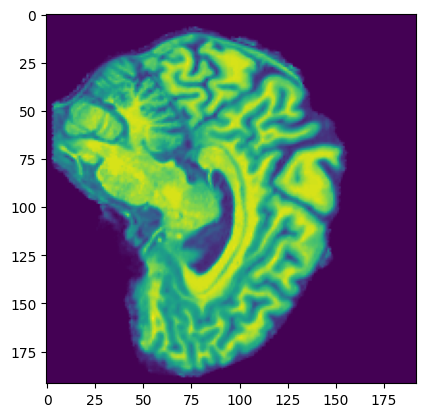

In [100]:
matplotlib.pyplot.imshow(img1[96,:,:])

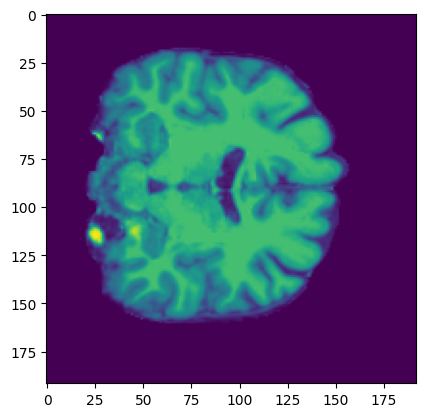

In [101]:
matplotlib.pyplot.imshow(img1[:,96,:])

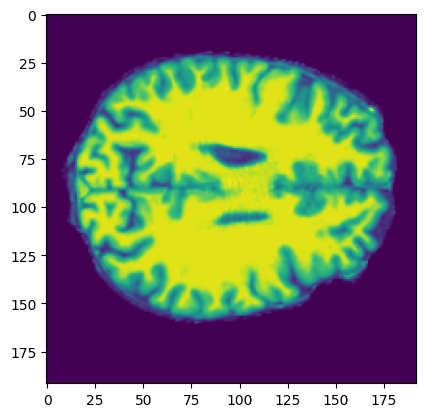

In [120]:
matplotlib.pyplot.imshow(img1[:,:,100])

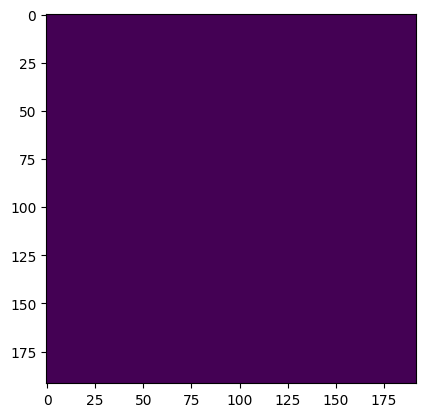

In [121]:
matplotlib.pyplot.imshow(mask1[0][:,:,100])

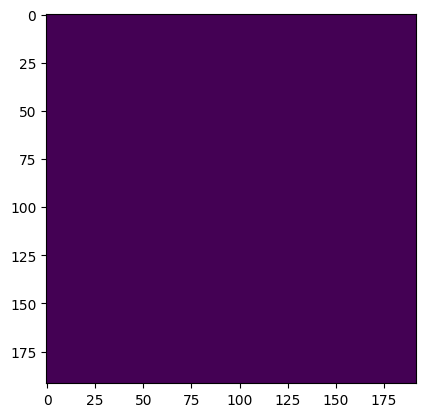

In [104]:
matplotlib.pyplot.imshow(mask1[1][:,:,96])

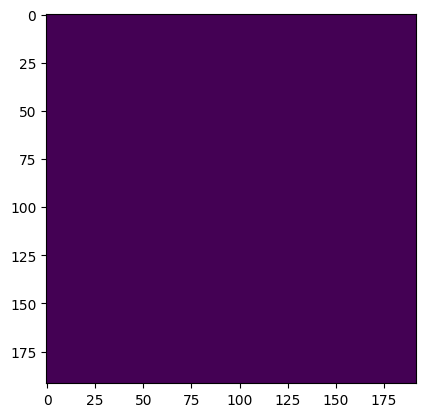

In [105]:
matplotlib.pyplot.imshow(mask1[2][:,:,96])

In [106]:
max(mask1[2],key=tuple)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [107]:
transform = T.ToPILImage()